## Penguin 6 types classification model

In [1]:
from keras import layers
from keras import models

# small CNN
def network(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

Using TensorFlow backend.


In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

base_dir = '/notebooks/penguins_128'
train_dir = os.path.join(base_dir, 'train')
input_shape=(128, 128, 3)
num_classes=6
batch_size=10
validation_split=0.2

class PenguinsDataset():
    def __init__(self, train_dir, batch_size, target_size, validation_split):
        self.train_dir = train_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.validation_split = validation_split

    
    def create_generator(self, IDG_options={}):
        default_IDG_options = {'rescale':1./255, 'validation_split':self.validation_split}
        IDG_options.update(default_IDG_options)
        self.train_datagen = ImageDataGenerator(**IDG_options)
        self.plain_datagen = ImageDataGenerator(**default_IDG_options)        
        self.train_gen = self.train_datagen.flow_from_directory(
                self.train_dir,
                target_size=self.target_size,
                batch_size=self.batch_size,
                class_mode='categorical',
                subset='training')
        if self.validation_split > 0:
            self.valid_gen = self.plain_datagen.flow_from_directory(
                    self.train_dir,               
                    target_size=self.target_size,
                    batch_size=self.batch_size,  
                    class_mode='categorical',
                    subset='validation')
        
        image_suffix = ['.jpg', '.JPG']
        self.train_files = [x for x in Path(train_dir).glob('*/*') if x.suffix in image_suffix]
        
    def train_steps_per_epoch(self):
        return int(len(self.train_files) * (1 - self.validation_split) // self.batch_size)
    
    def validation_steps_per_epoch(self):
        return int(len(self.train_files) * (self.validation_split) // self.batch_size)



In [3]:
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint

#  Trainer class
class Trainer():

    def __init__(self, model, loss, optimizer, log_dir, model_file_name):
        self._target = model
        self._target.compile(
            loss=loss, optimizer=optimizer, metrics=["acc"]
            )
        self.verbose = 1
        self.log_dir = log_dir
        self.model_file_name = model_file_name

    def train(self,ds, batch_size, epochs):
        if os.path.exists(self.log_dir):
            import shutil
            shutil.rmtree(self.log_dir)  # remove previous execution
        os.mkdir(self.log_dir)

        model_path = os.path.join(self.log_dir, self.model_file_name)
        callbacks = [
            TensorBoard(log_dir=self.log_dir),
            ModelCheckpoint(model_path, 
                    monitor='val_loss', verbose=1, save_best_only=True),
        ]
        self.history = self._target.fit_generator(ds.train_gen, 
                                   steps_per_epoch=ds.train_steps_per_epoch(),
                                   epochs=epochs,
                                   validation_data=ds.valid_gen,
                                   validation_steps=ds.validation_steps_per_epoch(),
                                   callbacks=callbacks,
                                    verbose=self.verbose)


In [4]:
import numpy as np

# for test datasets
class Tester:
    def __init__(self, test_dir, target_size):
        files_num = len([x for x in Path(test_dir).glob('*/*') if x.suffix in ['.jpg', '.JPG']])
        test_ds = PenguinsDataset(test_dir, files_num, target_size, 0)
        test_ds.create_generator({})
        self.test_generator = test_ds.train_gen
        self.x_test, self.y_test = next(self.test_generator)
        self.y_list=np.argmax(self.y_test, axis=1)
    
    def predict(self, model):
        self.preds = model.predict(self.x_test)
        results_list=np.argmax(self.preds, axis=1)
        self.correct_no_list = [i for i in range(len(self.y_list)) if self.y_list[i] == results_list[i]]
        self.in_correct_no_list = [i for i in range(len(self.y_list)) if self.y_list[i] != results_list[i]]


In [5]:
# grad-cam
import cv2
from keras import backend as K

labels=['adelie', 'chinstrap', 'emperor', 'gentoo', 'king', 'rockhopper']

def imshow_friendly(img):
    img_temp = img - np.min(img)
    img_temp = img_temp/np.max(img_temp)
    friendly = np.uint8(255 * img_temp)
    return friendly

def visualize_cam(model, test_file_index, layer_name, tester):
    last_conv_layer = model.get_layer(layer_name)
    x = np.array([tester.x_test[test_file_index]])
    targ_class = np.argmax(tester.preds[test_file_index])
    
    output = model.output[:, targ_class]
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(int(last_conv_layer.output.shape[3])):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img = tester.x_test[test_file_index]
    fig = plt.figure(figsize=(10, 5), dpi=100)
    ax = fig.add_subplot(131)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    ax.set_axis_off()
    ax.matshow(heatmap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = ((heatmap*0.5/np.max(heatmap) + img)) / 1.5
    ax = fig.add_subplot(132)
    ax.set_axis_off()
    ax.imshow(imshow_friendly(superimposed))
    ax.set_title('%s? %s' % (labels[targ_class], 'yes' if test_file_index in tester.correct_no_list else 'no'), fontsize=12)
    ax = fig.add_subplot(133)
    ax.set_axis_off()
    ax.imshow(imshow_friendly(img)) 
    


### 4 layers, without Augmentation

create_generatorのImageDataGeneratorオプションを渡していないので、デフォルトのrescaleとvalidation_splitだけ使われ、データ拡張しないデータセットになります。

In [6]:
# create Dataset(ImageDataGenerator)
ds = PenguinsDataset(train_dir, batch_size, input_shape[:2], validation_split)
ds.create_generator({})

model = network(input_shape, num_classes)
trainer = Trainer(model, loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), 
                  log_dir="scratch_no_aug", model_file_name="scratch_no_aug.h5")
trainer.train(ds, batch_size=batch_size, epochs=50)


Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Epoch 1/50
240/240 [==============================] - 3s 14ms/step - loss: 1.6978 - acc: 0.2675 - val_loss: 1.5647 - val_acc: 0.3750

Epoch 00001: val_loss improved from inf to 1.56469, saving model to scratch_no_aug/scratch_no_aug.h5
Epoch 2/50
240/240 [==============================] - 2s 10ms/step - loss: 1.4807 - acc: 0.3975 - val_loss: 1.4164 - val_acc: 0.4400

Epoch 00002: val_loss improved from 1.56469 to 1.41642, saving model to scratch_no_aug/scratch_no_aug.h5
Epoch 3/50
240/240 [==============================] - 2s 10ms/step - loss: 1.3194 - acc: 0.4683 - val_loss: 1.2761 - val_acc: 0.5017

Epoch 00003: val_loss improved from 1.41642 to 1.27614, saving model to scratch_no_aug/scratch_no_aug.h5
Epoch 4/50
240/240 [==============================] - 2s 10ms/step - loss: 1.1795 - acc: 0.5488 - val_loss: 1.1993 - val_acc: 0.5167

Epoch 00004: val_loss improved from 1.27614 to 1.19933, saving model t

240/240 [==============================] - 2s 9ms/step - loss: 0.0211 - acc: 0.9954 - val_loss: 2.5422 - val_acc: 0.6600

Epoch 00043: val_loss did not improve from 1.04187
Epoch 44/50
240/240 [==============================] - 2s 9ms/step - loss: 0.0149 - acc: 0.9975 - val_loss: 2.5213 - val_acc: 0.6500

Epoch 00044: val_loss did not improve from 1.04187
Epoch 45/50
240/240 [==============================] - 2s 9ms/step - loss: 0.0163 - acc: 0.9967 - val_loss: 2.7145 - val_acc: 0.6533

Epoch 00045: val_loss did not improve from 1.04187
Epoch 46/50
240/240 [==============================] - 2s 9ms/step - loss: 0.0237 - acc: 0.9962 - val_loss: 2.7200 - val_acc: 0.6317

Epoch 00046: val_loss did not improve from 1.04187
Epoch 47/50
240/240 [==============================] - 2s 9ms/step - loss: 0.0207 - acc: 0.9971 - val_loss: 2.8928 - val_acc: 0.6417

Epoch 00047: val_loss did not improve from 1.04187
Epoch 48/50
240/240 [==============================] - 2s 9ms/step - loss: 0.0204 - acc

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_graph(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # 正解率をプロット
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # 損失値をプロット
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

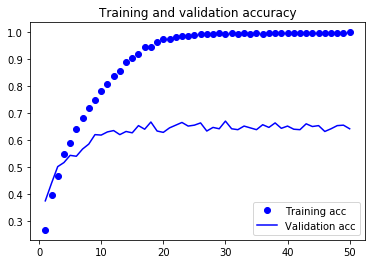

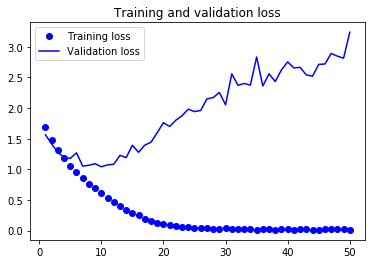

In [8]:
show_graph(trainer.history)

15epochくらいでvalidation accのほうはもう上がらなくなってしまったので、かなり過学習の傾向が見えます。
テスト用にとりわけておいた60枚x6種類のペンギン画像を使って、正解率を計算してみます。

In [9]:
tester = Tester(os.path.join(base_dir, 'test'), input_shape[:2] )
tester.predict(model)

score = model.evaluate(tester.x_test, tester.y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Found 360 images belonging to 6 classes.
Test loss: 3.2521327442593044
Test accuracy: 0.6361111111111111


検証の正解率とだいたいいっしょですね。

不正解画像のどこを見ていたのかをCAMで表示しましょう

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       147584    
__________

In [11]:
# 出力用テストデータセットを取得 (画像の著作権的に)
output_tester = Tester(os.path.join(base_dir, 'for_output'), input_shape[:2] )
output_tester.predict(model)
print(output_tester.correct_no_list)
print(output_tester.in_correct_no_list)

Found 42 images belonging to 6 classes.
[1, 2, 5, 6, 7, 9, 14, 15, 16, 17, 20, 22, 23, 25, 30, 32, 34, 37, 38, 39, 40]
[0, 3, 4, 8, 10, 11, 12, 13, 18, 19, 21, 24, 26, 27, 28, 29, 31, 33, 35, 36, 41]


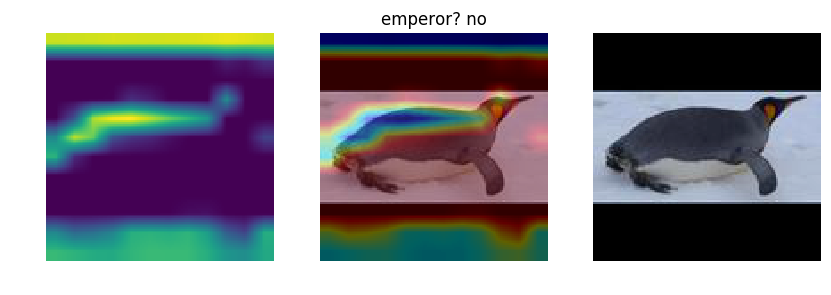

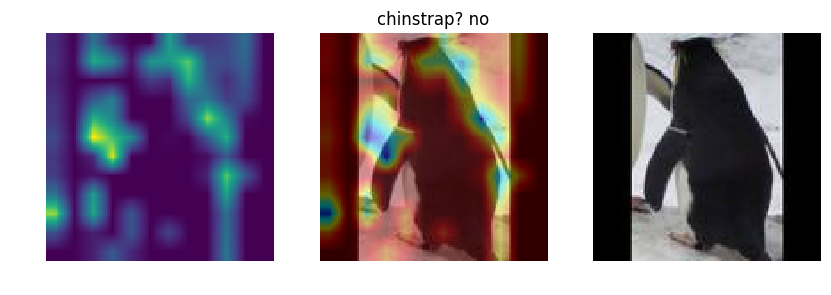

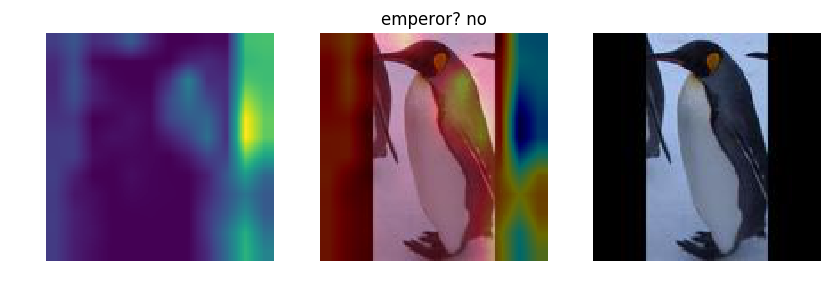

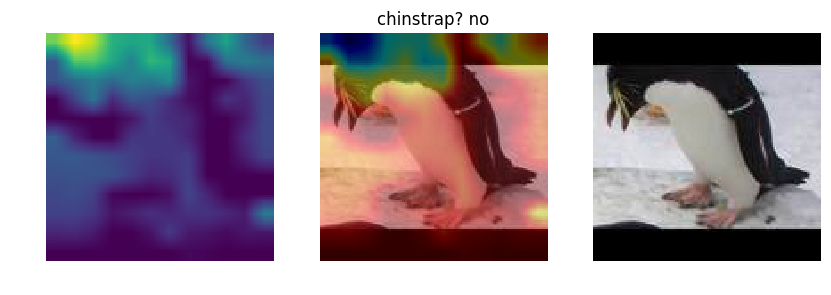

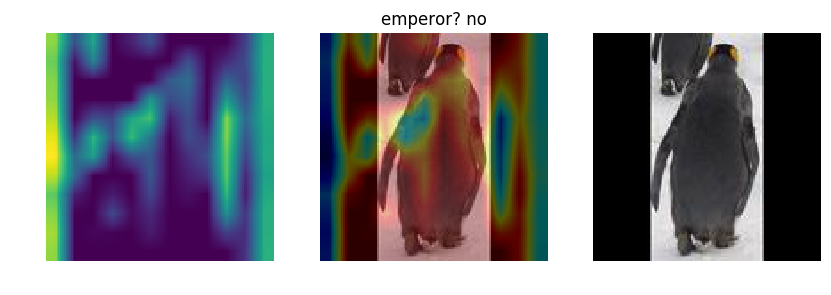

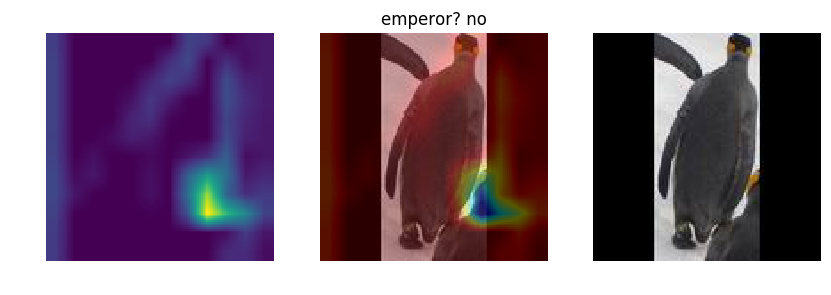

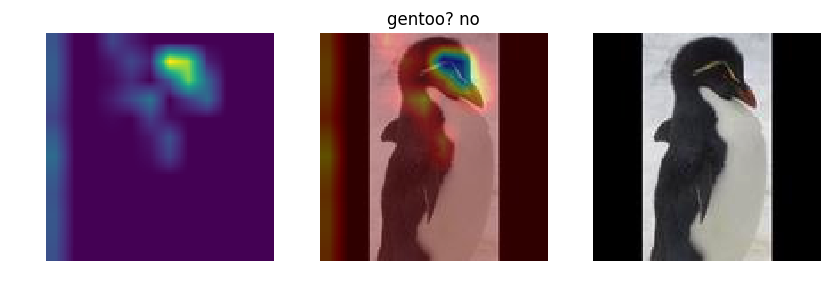

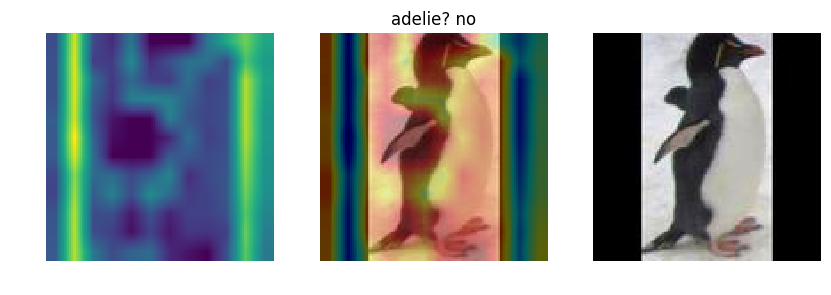

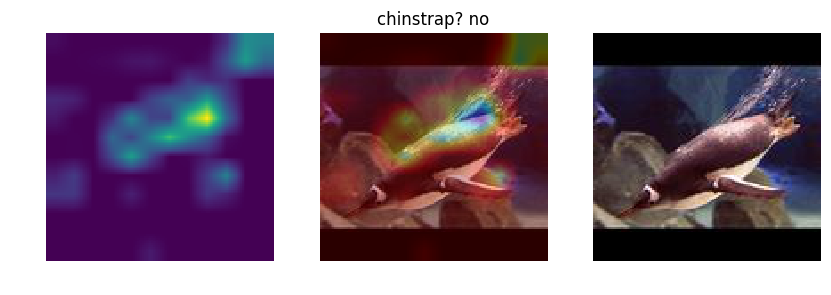

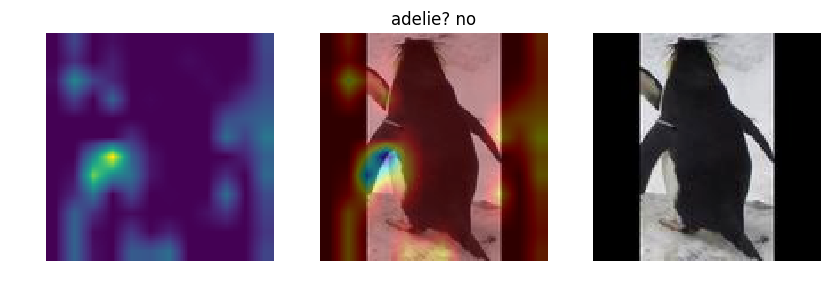

In [12]:
# 4層目の畳み込み層のどこを見ていたのか
for i in range(10):
    visualize_cam(model, output_tester.in_correct_no_list[i], 'conv2d_4', output_tester)
plt.show()

正解していたほうはどこを見ていたのか

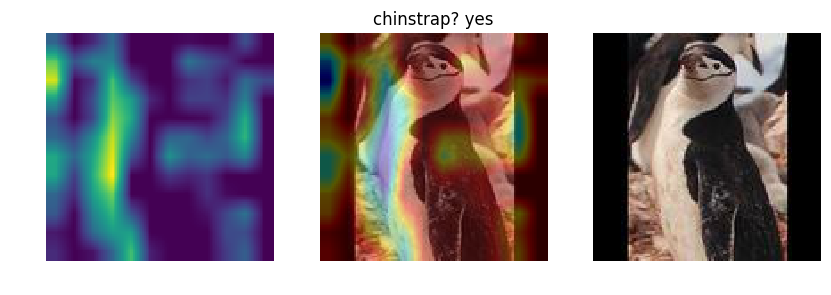

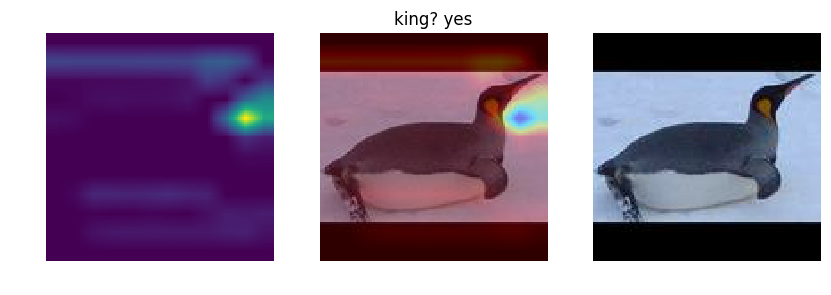

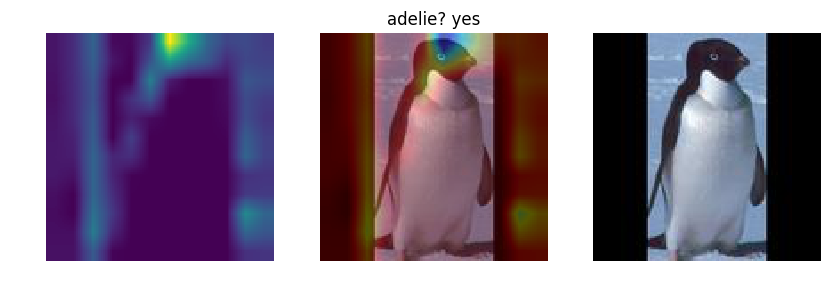

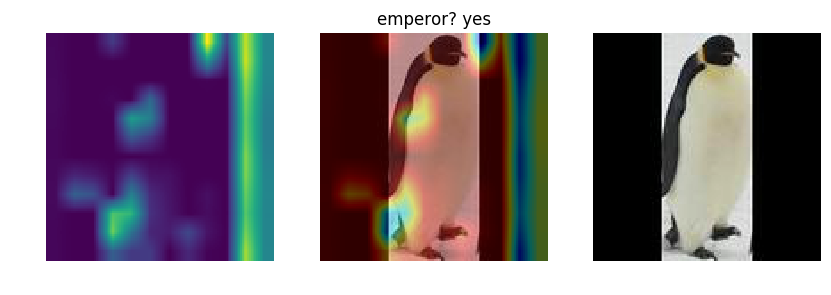

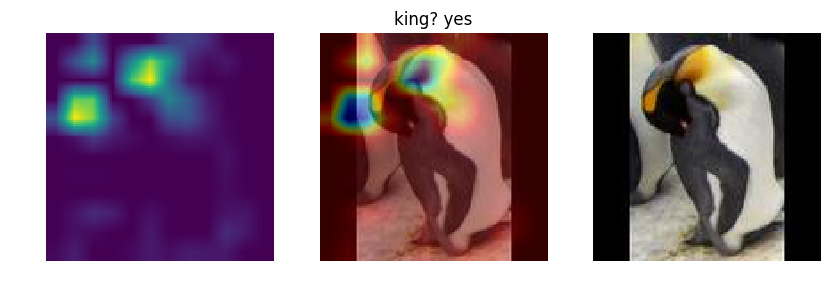

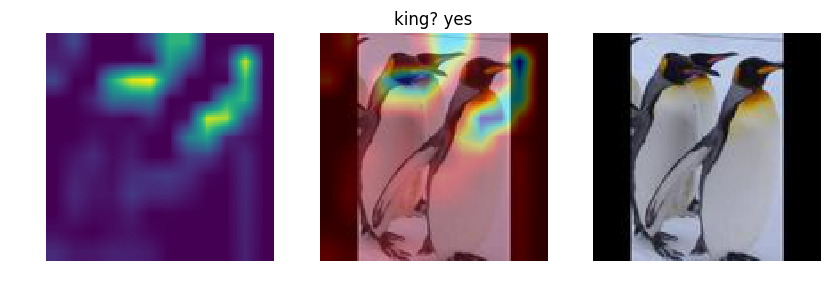

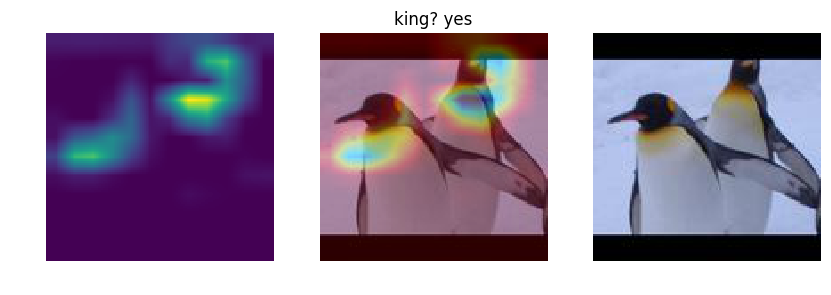

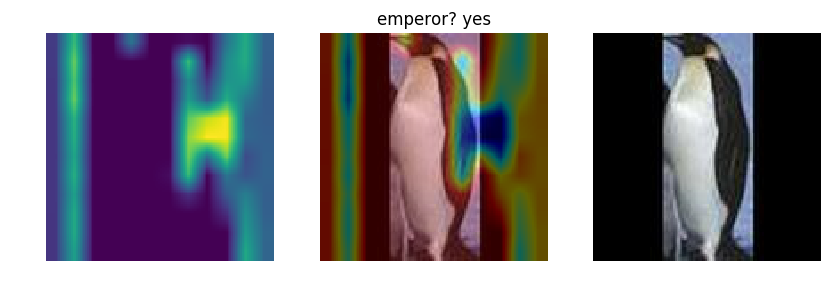

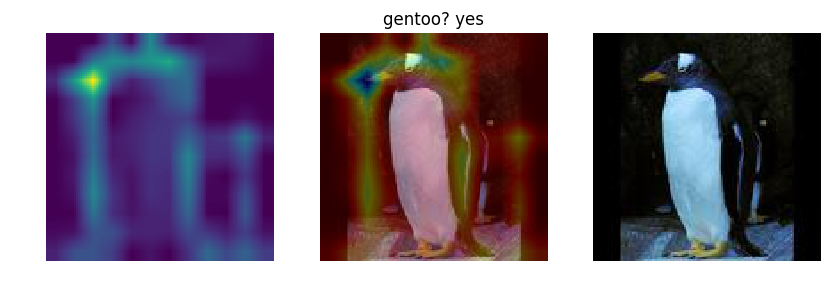

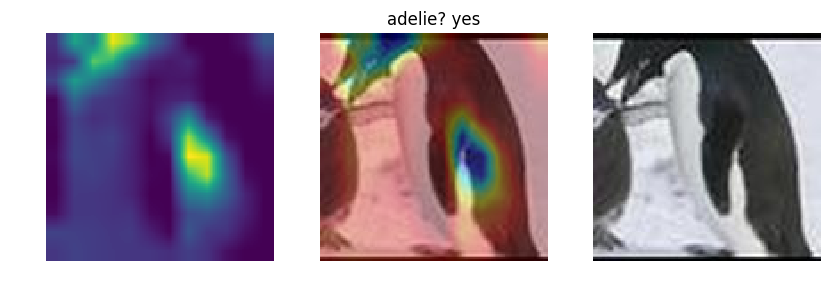

In [13]:
for i in range(10):
    visualize_cam(model, output_tester.correct_no_list[i], 'conv2d_4', output_tester)
plt.show()

かなりなあてずっぽ感があります。

### 4layers, Using Data Augmentation

データ拡張を行って同じ4層CNNで学習させます。

create_generatorにImageDataGeneratorに食わせるデータ拡張のオプションを渡しています。

In [14]:
ds.create_generator({'rotation_range':40, 
                     'width_shift_range':0.2, 
                     'height_shift_range':0.2, 
                     'shear_range':0.2, 
                     'zoom_range':0.2, 
                     'horizontal_flip':True, 
                     'fill_mode':'nearest'})

Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [15]:
model = network(input_shape, num_classes)
trainer = Trainer(model, loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), 
                  log_dir="scratch_aug", model_file_name="scratch_aug.h5")
trainer.train(ds, batch_size=batch_size, epochs=200)

Epoch 1/200
240/240 [==============================] - 7s 31ms/step - loss: 1.7712 - acc: 0.2183 - val_loss: 1.6971 - val_acc: 0.2550

Epoch 00001: val_loss improved from inf to 1.69706, saving model to scratch_aug/scratch_aug.h5
Epoch 2/200
240/240 [==============================] - 7s 30ms/step - loss: 1.7154 - acc: 0.2517 - val_loss: 1.6032 - val_acc: 0.3417

Epoch 00002: val_loss improved from 1.69706 to 1.60321, saving model to scratch_aug/scratch_aug.h5
Epoch 3/200
240/240 [==============================] - 7s 30ms/step - loss: 1.5952 - acc: 0.3400 - val_loss: 1.5025 - val_acc: 0.3767

Epoch 00003: val_loss improved from 1.60321 to 1.50249, saving model to scratch_aug/scratch_aug.h5
Epoch 4/200
240/240 [==============================] - 7s 30ms/step - loss: 1.4959 - acc: 0.3900 - val_loss: 1.4707 - val_acc: 0.4250

Epoch 00004: val_loss improved from 1.50249 to 1.47075, saving model to scratch_aug/scratch_aug.h5
Epoch 5/200
240/240 [==============================] - 7s 30ms/step 

240/240 [==============================] - 7s 30ms/step - loss: 0.7267 - acc: 0.7279 - val_loss: 0.8112 - val_acc: 0.7200

Epoch 00039: val_loss did not improve from 0.67013
Epoch 40/200
240/240 [==============================] - 7s 30ms/step - loss: 0.7097 - acc: 0.7342 - val_loss: 0.6997 - val_acc: 0.7417

Epoch 00040: val_loss did not improve from 0.67013
Epoch 41/200
240/240 [==============================] - 7s 30ms/step - loss: 0.6923 - acc: 0.7425 - val_loss: 0.6659 - val_acc: 0.7650

Epoch 00041: val_loss improved from 0.67013 to 0.66595, saving model to scratch_aug/scratch_aug.h5
Epoch 42/200
240/240 [==============================] - 7s 30ms/step - loss: 0.7005 - acc: 0.7412 - val_loss: 0.7155 - val_acc: 0.7383

Epoch 00042: val_loss did not improve from 0.66595
Epoch 43/200
240/240 [==============================] - 7s 30ms/step - loss: 0.7054 - acc: 0.7358 - val_loss: 0.6215 - val_acc: 0.7883

Epoch 00043: val_loss improved from 0.66595 to 0.62146, saving model to scratch_a

240/240 [==============================] - 7s 30ms/step - loss: 0.5104 - acc: 0.8254 - val_loss: 0.6692 - val_acc: 0.8033

Epoch 00081: val_loss did not improve from 0.56209
Epoch 82/200
240/240 [==============================] - 7s 30ms/step - loss: 0.4777 - acc: 0.8283 - val_loss: 0.7362 - val_acc: 0.7933

Epoch 00082: val_loss did not improve from 0.56209
Epoch 83/200
240/240 [==============================] - 7s 30ms/step - loss: 0.4955 - acc: 0.8154 - val_loss: 0.8644 - val_acc: 0.7667

Epoch 00083: val_loss did not improve from 0.56209
Epoch 84/200
240/240 [==============================] - 7s 30ms/step - loss: 0.4807 - acc: 0.8325 - val_loss: 0.6851 - val_acc: 0.8117

Epoch 00084: val_loss did not improve from 0.56209
Epoch 85/200
240/240 [==============================] - 7s 30ms/step - loss: 0.4756 - acc: 0.8229 - val_loss: 0.7907 - val_acc: 0.7983

Epoch 00085: val_loss did not improve from 0.56209
Epoch 86/200
240/240 [==============================] - 7s 30ms/step - loss: 0

240/240 [==============================] - 7s 30ms/step - loss: 0.3991 - acc: 0.8646 - val_loss: 0.6168 - val_acc: 0.8417

Epoch 00124: val_loss did not improve from 0.55356
Epoch 125/200
240/240 [==============================] - 7s 30ms/step - loss: 0.4016 - acc: 0.8600 - val_loss: 0.7049 - val_acc: 0.8250

Epoch 00125: val_loss did not improve from 0.55356
Epoch 126/200
240/240 [==============================] - 7s 30ms/step - loss: 0.3997 - acc: 0.8575 - val_loss: 0.6183 - val_acc: 0.8483

Epoch 00126: val_loss did not improve from 0.55356
Epoch 127/200
240/240 [==============================] - 7s 30ms/step - loss: 0.4048 - acc: 0.8592 - val_loss: 0.5854 - val_acc: 0.8533

Epoch 00127: val_loss did not improve from 0.55356
Epoch 128/200
240/240 [==============================] - 7s 30ms/step - loss: 0.3790 - acc: 0.8579 - val_loss: 0.6154 - val_acc: 0.8500

Epoch 00128: val_loss did not improve from 0.55356
Epoch 129/200
240/240 [==============================] - 7s 30ms/step - lo

240/240 [==============================] - 7s 30ms/step - loss: 0.3682 - acc: 0.8783 - val_loss: 0.6922 - val_acc: 0.8417

Epoch 00167: val_loss did not improve from 0.53399
Epoch 168/200
240/240 [==============================] - 7s 30ms/step - loss: 0.3505 - acc: 0.8783 - val_loss: 0.5885 - val_acc: 0.8400

Epoch 00168: val_loss did not improve from 0.53399
Epoch 169/200
240/240 [==============================] - 7s 30ms/step - loss: 0.3526 - acc: 0.8812 - val_loss: 0.5792 - val_acc: 0.8567

Epoch 00169: val_loss did not improve from 0.53399
Epoch 170/200
240/240 [==============================] - 7s 30ms/step - loss: 0.3255 - acc: 0.8942 - val_loss: 0.6541 - val_acc: 0.8600

Epoch 00170: val_loss did not improve from 0.53399
Epoch 171/200
240/240 [==============================] - 7s 30ms/step - loss: 0.3344 - acc: 0.8871 - val_loss: 0.7350 - val_acc: 0.8400

Epoch 00171: val_loss did not improve from 0.53399
Epoch 172/200
240/240 [==============================] - 7s 30ms/step - lo

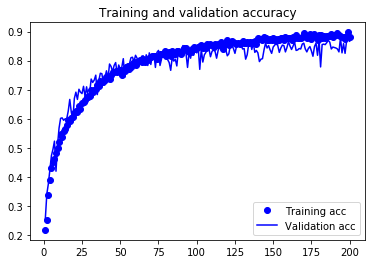

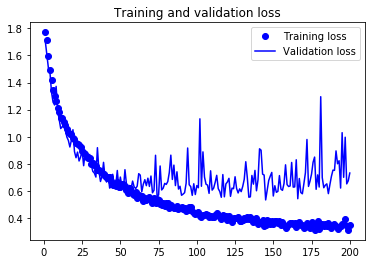

In [16]:
show_graph(trainer.history)

In [17]:
tester = Tester(os.path.join(base_dir, 'test'), input_shape[:2] )
tester.predict(model)

score = model.evaluate(tester.x_test, tester.y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Found 360 images belonging to 6 classes.
Test loss: 0.5878314203686185
Test accuracy: 0.875


正解率はかなりあがりました。では、CAMで見てみます。

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       147584    
__________

In [19]:
output_tester = Tester(os.path.join(base_dir, 'for_output'), input_shape[:2] )
output_tester.predict(model)
print(output_tester.correct_no_list)
print(output_tester.in_correct_no_list)

Found 42 images belonging to 6 classes.
[2, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 35, 36, 37, 38, 40, 41]
[0, 1, 3, 4, 7, 14, 20, 31, 33, 34, 39]


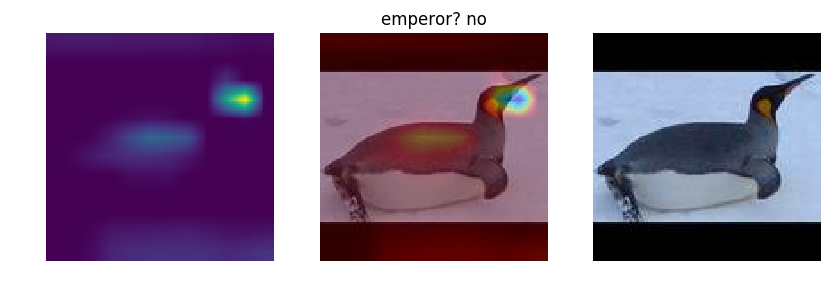

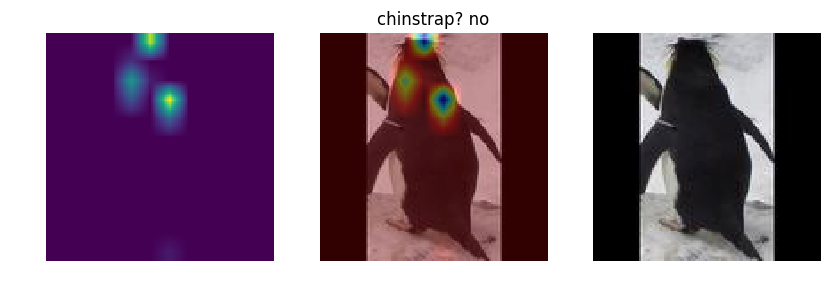

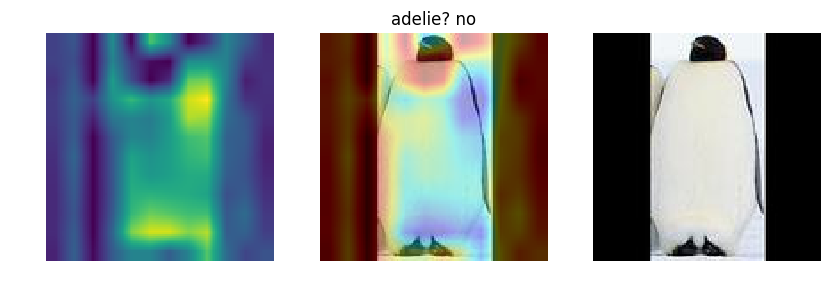

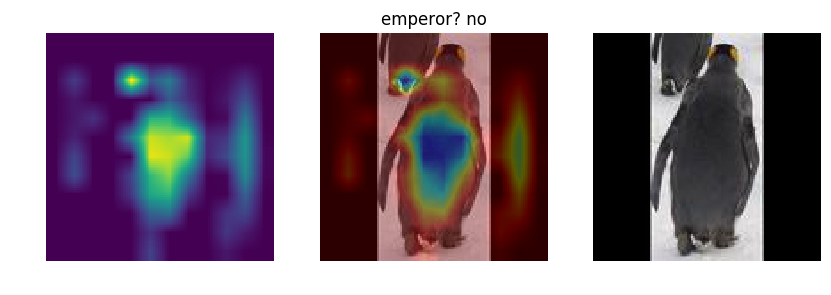

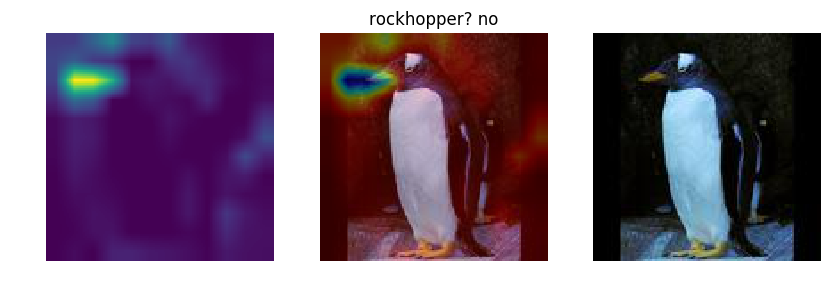

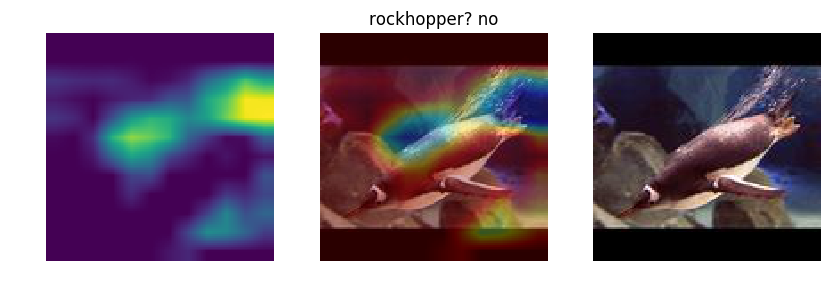

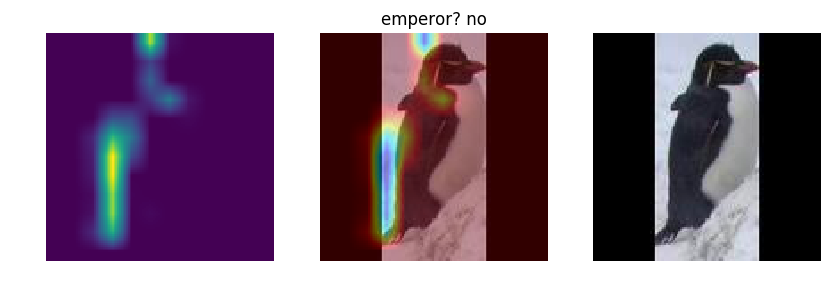

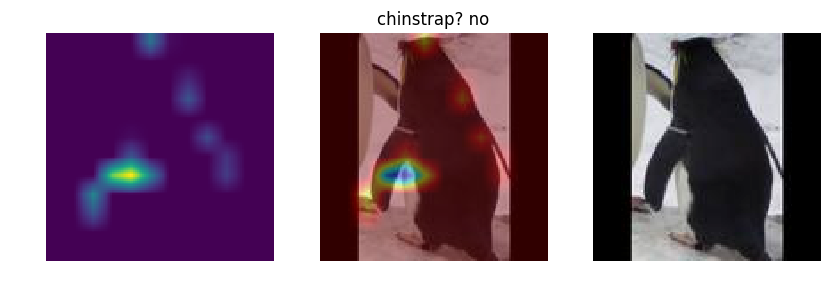

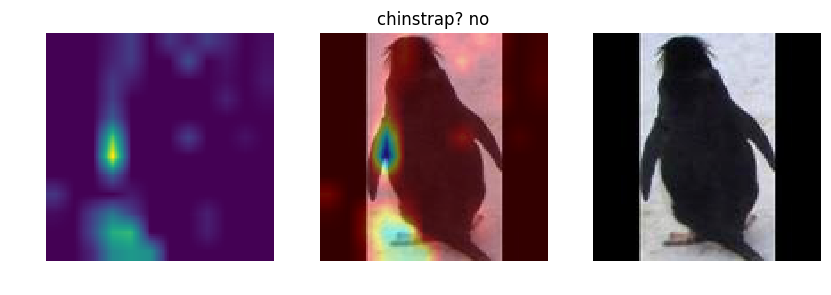

In [20]:
for i in range(9):
    visualize_cam(model, output_tester.in_correct_no_list[i], 'conv2d_8', output_tester)
plt.show()

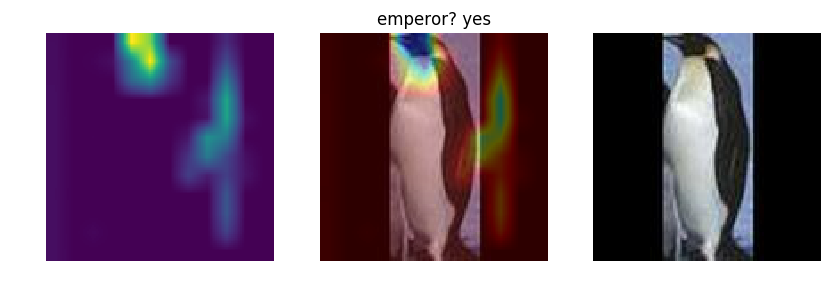

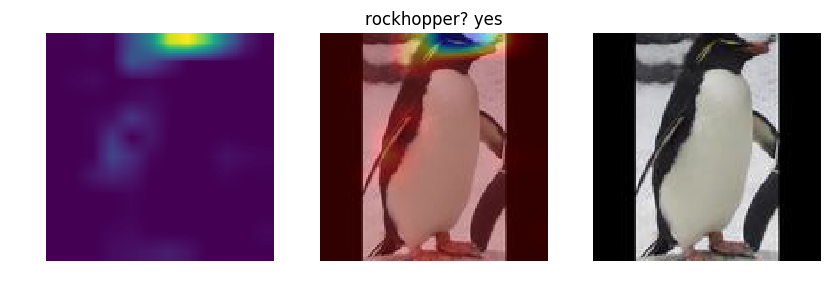

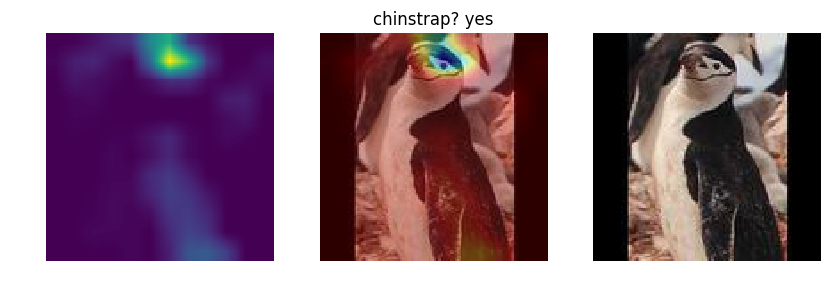

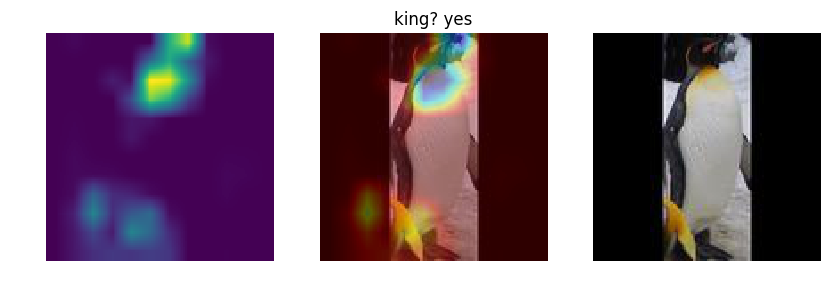

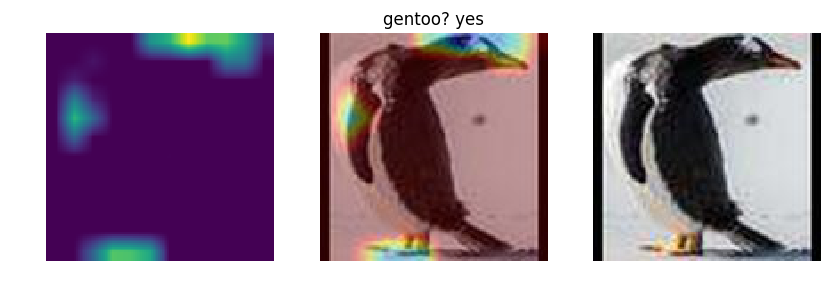

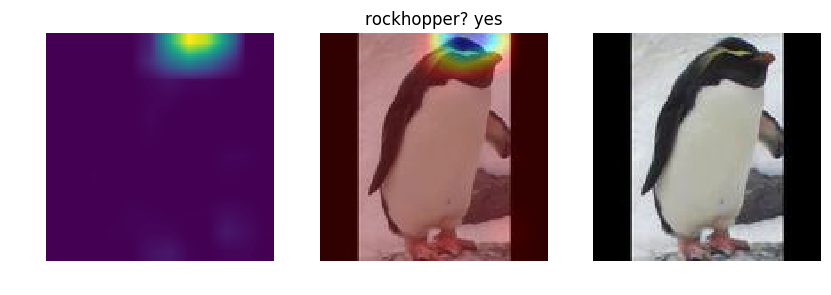

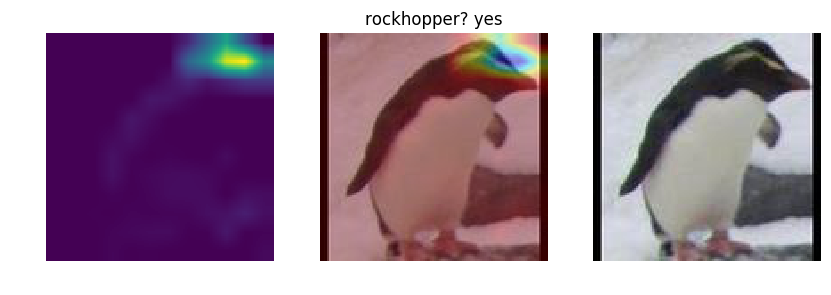

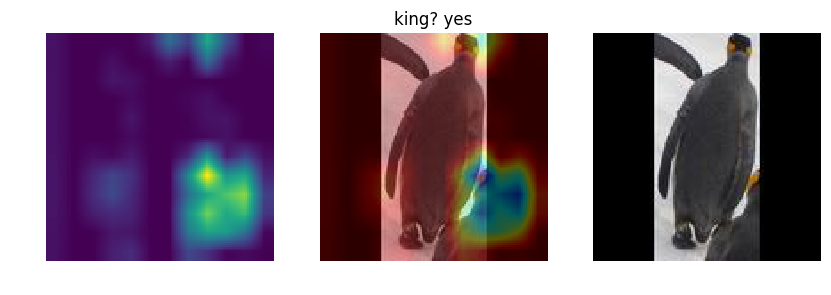

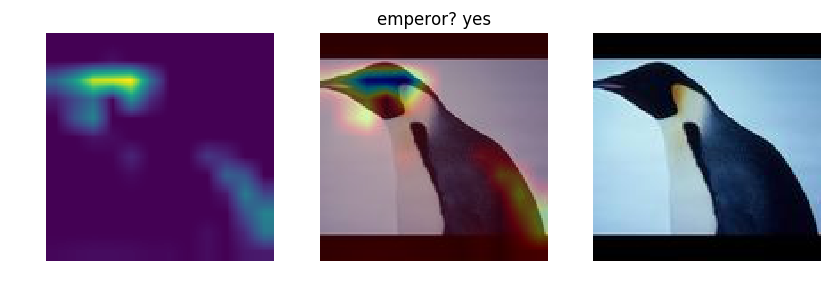

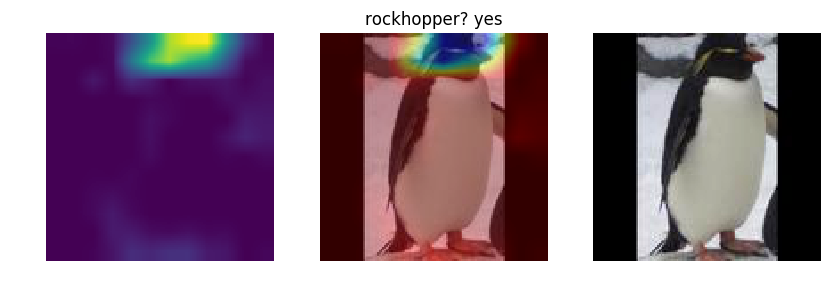

In [21]:
for i in range(10):
    visualize_cam(model, output_tester.correct_no_list[i], 'conv2d_8', output_tester)
plt.show()

さっきのデータ拡張なしのmodelと比べると、見るべきポイントは正しくなっているように見えます。